# Adaptive Distances

In this example, we show how and when to use the adaptive distances feature of pyabc. "Adaptive distances" means that the distance function is not pre-defined (e.g. after pre-processing), but evolves over time during the ABC run, depending on the observed summary statistics. This can be useful if different summary statistics vary on different scales, but it is not immediately clear how to weight them. For this case, in adaptive distances weights are adjusted in each iteration so as to balance the impact of all summary statistics on the computed distance. 

Currently, adaptively weighted p-norm distances (e.g. Euclidean) are implemented in pyABC, but it is easily possible to define arbitrary adaptive distances.

For illustration, we consider a simple Gaussian model:

In [1]:
import scipy
import tempfile
import os
import matplotlib.pyplot as pyplot
import pyabc.visualization
import logging


# for debugging
df_logger = logging.getLogger('Distance')
df_logger.setLevel(logging.DEBUG)

# model definition
def model(p):
    return {'ss1': p['theta'] + 1 + 0.1 * scipy.randn(),
            'ss2': 2 + 10 * scipy.randn()}

# true model parameter
theta_true = 3

# observed summary statistics
observation = {'ss1': theta_true + 1, 'ss2': 2}

# prior distribution
prior = pyabc.Distribution(theta=pyabc.RV('uniform', 0, 10))

# database
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")

Summary statistic ss2 has a high variance compared to summary statistic ss1. In addition, ss1 is informative about the model parameters $\theta$, ss2 not. We expect that the proposal distribution for $\theta$ iteratively centers around the true value $\theta=3$. Thus, the variability for the sampled ss1 decreases iteratively, while the variability of the sampled ss2 stays approximately constant. If both summary statistics are weighted similarly in the calculation of the distance between sample and observation, there is hence an undesirable high impact of ss2, so that convergence can be slowed down. In contrast, if we weight ss1 higher, we may hope that our estimation of $\theta$ is improved.

These informal expectations being stated, let us continue with the implementation. First, we consider a non-adaptive Euclidean distance:

In [2]:
distance = pyabc.PNormDistance(p=2)

abc = pyabc.ABCSMC(model, prior, distance)

abc.new(db_path, observation)

history0 = abc.run(minimum_epsilon=.1, max_nr_populations=8)

INFO:History:Start <ABCSMC(id=1, start_time=2019-10-07 12:02:45.973821, end_time=None)>
INFO:Epsilon:initial epsilon is 7.8417339669506285
INFO:ABC:t:0 eps:7.8417339669506285
INFO:ABC:t:1 eps:5.102299012056807
INFO:ABC:t:2 eps:3.256607528184582
INFO:ABC:t:3 eps:2.19387520983454
INFO:ABC:t:4 eps:1.5711687146533853
INFO:ABC:t:5 eps:1.1161184506934003
INFO:ABC:t:6 eps:0.7556388688924657
INFO:ABC:t:7 eps:0.5524331380576925
INFO:History:Done <ABCSMC(id=1, start_time=2019-10-07 12:02:45.973821, end_time=2019-10-07 12:03:02.008709)>


Let us visualize the results for the non-adaptive distance:

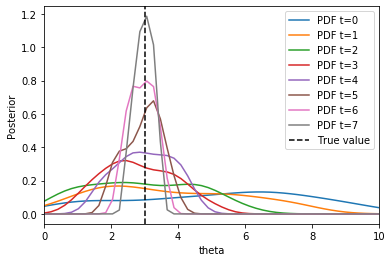

In [3]:
# plotting

def plot_history(history):
    fig, ax = pyplot.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=10,
                                       x='theta', ax=ax,
                                       label="PDF t={}".format(t))
    ax.axvline(theta_true, color='k', linestyle='dashed', label="True value")
    ax.legend()


plot_history(history0)

Second, we consider an adaptive Euclidean distance:

In [4]:
distance_adaptive = pyabc.AdaptivePNormDistance(p=2)

abc = pyabc.ABCSMC(
    model, prior, distance_adaptive,
    acceptor = pyabc.acceptor.accept_use_complete_history)

abc.new(db_path, observation)

history1 = abc.run(minimum_epsilon=.1, max_nr_populations=8)

INFO:History:Start <ABCSMC(id=2, start_time=2019-10-07 12:03:02.546661, end_time=None)>
DEBUG:Distance:updated weights[0] = {'ss1': 1.5330024727552716, 'ss2': 0.46699752724472837}
INFO:Epsilon:initial epsilon is 6.6850052783116745
INFO:ABC:t:0 eps:6.6850052783116745
DEBUG:Distance:updated weights[1] = {'ss1': 1.5302546181397103, 'ss2': 0.46974538186028963}
INFO:ABC:t:1 eps:4.474861126835958
DEBUG:Distance:updated weights[2] = {'ss1': 1.6774812598034334, 'ss2': 0.3225187401965667}
INFO:ABC:t:2 eps:2.787946404773433
DEBUG:Distance:updated weights[3] = {'ss1': 1.7379219334323655, 'ss2': 0.2620780665676344}
INFO:ABC:t:3 eps:1.7660702437483857
DEBUG:Distance:updated weights[4] = {'ss1': 1.839805957109813, 'ss2': 0.1601940428901867}
INFO:ABC:t:4 eps:1.0368105331648945
DEBUG:Distance:updated weights[5] = {'ss1': 1.896333672974677, 'ss2': 0.10366632702532297}
INFO:ABC:t:5 eps:0.6329734676552894
DEBUG:Distance:updated weights[6] = {'ss1': 1.9249788011040878, 'ss2': 0.07502119889591205}
INFO:ABC

In the debug output of abc.run above, it can be seen how the weights evolve over time. Note that we set the acceptor to ``pyabc.acceptor.accept_use_complete_history`` instead of the default ``pyabc.acceptor.accept_use_current_time`` in order to get nested acceptance regions. This is optional here but may be beneficial sometimes. Let us visualize the results for the adaptive distance:

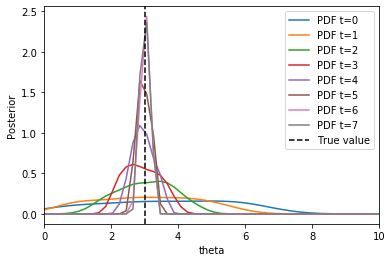

In [5]:
plot_history(history1)

We observe differences compared to the non-adaptive setting. In particular, the densitities tend to be narrower around the true parameter $\theta=3$. In addition, despite the better convergence, the required number of samples in total is lower, as not so much time was wasted trying to match an uninformative summary statistic:

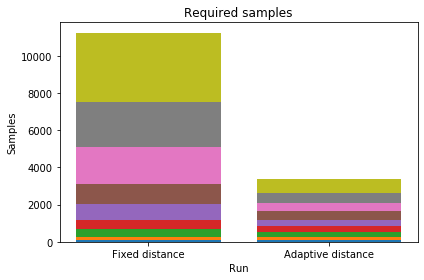

In [6]:
pyabc.visualization.plot_sample_numbers([history0, history1], ["Fixed distance", "Adaptive distance"])

In detail, the adaptive distance feature works as follows: In each iteration of the ABCSMC run, after having obtained the desired number of accepted particles (and once at the beginning using a sample from the prior), the method ``DistanceFunction.update()`` is called. It is given a set of summary statistics which can be used to e.g. compute weights for the distance measure in the next iteration. In order to avoid bias, via ``DistanceFunction.configure_sampler()``, the distance function can tell the sampler to not only record accepted particles, but all that were generated during the sampling process.
So, when you want to define your own adaptive distance function, you will typically only need to overwrite these two methods. For implementation details and an example of how this can look in practice, please inspect the code of ``AdaptivePNormDistance``.

## Make it robust

A problem with the previous adaptive distance occurs when the weights do not work properly. For instance, there could be large weights assigned to rather non-informative statistics, if these vary comparably little. Let us have a look at an example:

In [7]:
import scipy
import tempfile
import os
import matplotlib.pyplot as pyplot
import pyabc.visualization
import logging


# for debugging
df_logger = logging.getLogger('Distance')
df_logger.setLevel(logging.DEBUG)

# model definition
def model(p):
    return {'ss1': p['theta'] + 1 + 1 * scipy.randn(),
            'ss2': 2 + 0.01 * scipy.randn()}

# true model parameter
theta_true = 3

# observed summary statistics
observation = {'ss1': theta_true + 1, 'ss2': 5}

# prior distribution
prior = pyabc.Distribution(theta=pyabc.RV('uniform', 0, 10))

# database
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")


# plotting

def plot_history(history):
    fig, ax = pyplot.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=10,
                                       x='theta', ax=ax,
                                       label="PDF t={}".format(t))
    ax.axvline(theta_true, color='k', linestyle='dashed', label="True value")
    ax.legend()

Essentially, we changed the variances of the two summary statistics, and in addition we shifted the observed value `ss2` to 5, which can be interpreted as a measurement error. Now the problem is that this value is highly unlikely to sample from under the model, and when using adaptive weights, this statistic might due to the small variance be assigned a high weight, worsening the problem.

INFO:History:Start <ABCSMC(id=3, start_time=2019-10-07 12:03:10.798572, end_time=None)>
INFO:Epsilon:initial epsilon is 3.867843314524691
INFO:ABC:t:0 eps:3.867843314524691
INFO:ABC:t:1 eps:3.2467828882337018
INFO:ABC:t:2 eps:3.057860174025457
INFO:ABC:t:3 eps:3.0128385272987295
INFO:ABC:t:4 eps:3.002744408281266
INFO:History:Done <ABCSMC(id=3, start_time=2019-10-07 12:03:10.798572, end_time=2019-10-07 12:03:16.265415)>


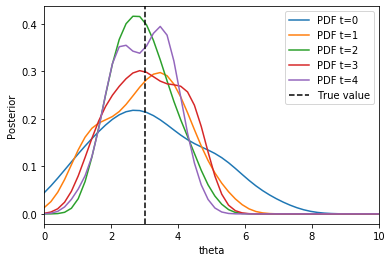

In [8]:
distance = pyabc.PNormDistance(p=2)

abc = pyabc.ABCSMC(model, prior, distance)
abc.new(db_path, observation)
history0 = abc.run(minimum_epsilon=.001, max_nr_populations=5)

plot_history(history0)

INFO:History:Start <ABCSMC(id=4, start_time=2019-10-07 12:03:16.605769, end_time=None)>
DEBUG:Distance:updated weights[0] = {'ss1': 0.005135871169798519, 'ss2': 1.9948641288302016}
INFO:Epsilon:initial epsilon is 5.982085387201624
INFO:ABC:t:0 eps:5.982085387201624
DEBUG:Distance:updated weights[1] = {'ss1': 0.006329690684650861, 'ss2': 1.993670309315349}
INFO:ABC:t:1 eps:5.968095801817932
DEBUG:Distance:updated weights[2] = {'ss1': 0.006691425200891954, 'ss2': 1.9933085747991082}
INFO:ABC:t:2 eps:5.958890954802979
DEBUG:Distance:updated weights[3] = {'ss1': 0.006706362487241605, 'ss2': 1.9932936375127583}
INFO:ABC:t:3 eps:5.9514342539464735
DEBUG:Distance:updated weights[4] = {'ss1': 0.006624344095324027, 'ss2': 1.993375655904676}
INFO:ABC:t:4 eps:5.945816974221296
DEBUG:Distance:updated weights[5] = {'ss1': 0.006853867745900646, 'ss2': 1.9931461322540993}
INFO:History:Done <ABCSMC(id=4, start_time=2019-10-07 12:03:16.605769, end_time=2019-10-07 12:03:27.476420)>


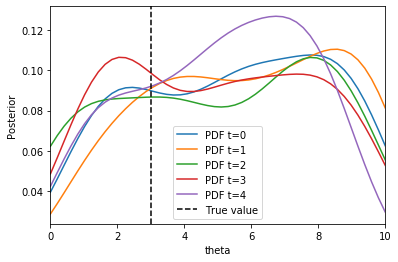

In [9]:
distance_adaptive = pyabc.AdaptivePNormDistance(p=2)

abc = pyabc.ABCSMC(
    model, prior, distance_adaptive,
    acceptor = pyabc.acceptor.accept_use_complete_history)
abc.new(db_path, observation)
history1 = abc.run(minimum_epsilon=.001, max_nr_populations=5)

plot_history(history1)

These results are as expected: The adaptive weights make the situation much worse. Our solution is to in addition to the in-sample variance also take the bias of the samples to the observed data into account, using e.g. the `root_mean_square_deviation` as scale function.

INFO:History:Start <ABCSMC(id=5, start_time=2019-10-07 12:03:27.906034, end_time=None)>
DEBUG:Distance:updated weights[0] = {'ss1': 0.9521504102902945, 'ss2': 1.0478495897097055}
INFO:Epsilon:initial epsilon is 3.816086450367168
INFO:ABC:t:0 eps:3.816086450367168
DEBUG:Distance:updated weights[1] = {'ss1': 0.9272451112208735, 'ss2': 1.0727548887791263}
INFO:ABC:t:1 eps:3.379024691469752
DEBUG:Distance:updated weights[2] = {'ss1': 1.212135484803433, 'ss2': 0.7878645151965671}
INFO:ABC:t:2 eps:2.4773389352643727
DEBUG:Distance:updated weights[3] = {'ss1': 1.311039267603122, 'ss2': 0.688960732396878}
INFO:ABC:t:3 eps:2.0997829425888908
DEBUG:Distance:updated weights[4] = {'ss1': 1.3535978365465289, 'ss2': 0.6464021634534711}
INFO:ABC:t:4 eps:1.9476010392554162
DEBUG:Distance:updated weights[5] = {'ss1': 1.3657377246907874, 'ss2': 0.6342622753092125}
INFO:History:Done <ABCSMC(id=5, start_time=2019-10-07 12:03:27.906034, end_time=2019-10-07 12:03:33.297756)>


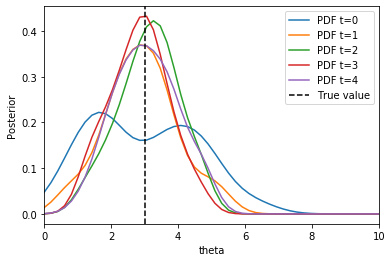

In [10]:
distance_adaptive = pyabc.AdaptivePNormDistance(
    p=2, scale_function=pyabc.distance.root_mean_square_deviation)

abc = pyabc.ABCSMC(
    model, prior, distance_adaptive,
    acceptor = pyabc.acceptor.accept_use_complete_history)
abc.new(db_path, observation)
history2 = abc.run(minimum_epsilon=.001, max_nr_populations=5)

plot_history(history2)

In this setting, the accuracy and sample numbers (see below) are rougly back to the non-weighted case. Applying this method to the first model shows that it is also applicable there, though potentially slightly less efficient. This demonstrates that this method is more robust in taking model error into account, which in practice can easily occur.

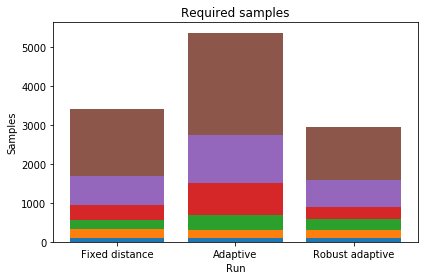

In [11]:
pyabc.visualization.plot_sample_numbers([history0, history1, history2], ["Fixed distance", "Adaptive", "Robust adaptive"])

## Weight diverse data with replicates

The problem we consider now is that we can separate our summary statistics (=data) into subsets which are informative for different parameters, but the sizes of these subsets are not balanced. This happens frequently in practice, e.g. when one has a time series of 100 measurements, compared to a single data point. If these two statistics are informative for different parameters, then the impact of the first kind on the computed distance value can be overly high, and in addition the automatic weighting as introduced by Prangle 2017 may not reduce, or can indeed even worsen, the problem.

Thus, what we want to do is add additional "factors" by which we multiply each data point's weight. These factors take into account the number of summary statistics that are equally informative. At the moment, these factors still need to be defined manually.

Let us consider a toy model, where we just copy a single summary statistic N0=100 times. Note that this model is highly artificical, as in practise there might be more information contained in e.g. a time series than in a single measurement, but not N0 times as much, such that a good factor would be somewhere between 1 and N0.

In [12]:
import pyabc
import numpy as np
import scipy as sp
import os
import tempfile
import matplotlib.pyplot as plt
import logging

# for debugging
df_logger = logging.getLogger('Distance')
df_logger.setLevel(logging.INFO)

N0 = 100
N1 = 1

p_true = {'p0': 5, 'p1': 10}

def model(p):
    ss = {}
    s0 = p['p0'] + 2 * sp.randn()
    for j in range(N0):
        ss['p0_' + str(j)] = s0
    s1 = p['p1'] + 0.01 * sp.randn()
    for j in range(N1):
        ss['p1_' + str(j)] = s1
    return ss

prior = pyabc.Distribution(p0=pyabc.RV("uniform", 0, 20),
                           p1=pyabc.RV("uniform", 0, 20))

First, we consider uniform weights of 1:

In [13]:
distance = pyabc.PNormDistance(p=1)

abc = pyabc.ABCSMC(model, prior, distance)

observation = model(p_true)

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history1 = abc.run(max_nr_populations=8)

INFO:History:Start <ABCSMC(id=6, start_time=2019-10-07 12:03:33.811604, end_time=None)>
INFO:Epsilon:initial epsilon is 517.2468447857065
INFO:ABC:t:0 eps:517.2468447857065
INFO:ABC:t:1 eps:252.03553943725296
INFO:ABC:t:2 eps:129.03208946693078
INFO:ABC:t:3 eps:68.87623766586985
INFO:ABC:t:4 eps:38.700512616258564
INFO:ABC:t:5 eps:23.064858105022086
INFO:ABC:t:6 eps:13.82287751727825
INFO:ABC:t:7 eps:10.097633611039162
INFO:History:Done <ABCSMC(id=6, start_time=2019-10-07 12:03:33.811604, end_time=2019-10-07 12:04:21.401916)>


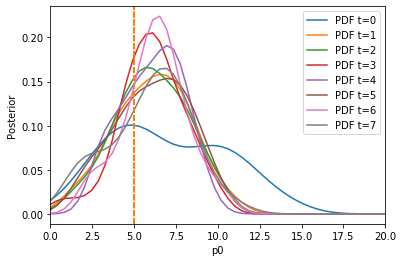

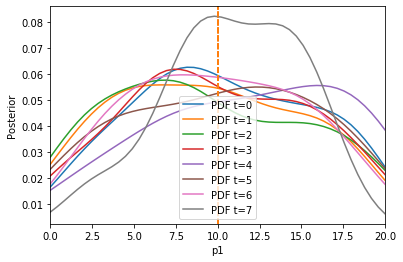

In [14]:
# plotting

def plot_history(history):
    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=20,
                                        x='p0', ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()

    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=20,
                                        x='p1', ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()
    
plot_history(history1)

Next, we use adaptive distances but no factors:

INFO:History:Start <ABCSMC(id=7, start_time=2019-10-07 12:04:22.248830, end_time=None)>
INFO:Epsilon:initial epsilon is 506.2167059374776
INFO:ABC:t:0 eps:506.2167059374776
INFO:ABC:t:1 eps:242.0231138606959
INFO:ABC:t:2 eps:132.1347392856356
INFO:ABC:t:3 eps:61.642547281342395
INFO:ABC:t:4 eps:29.80968246824237
INFO:ABC:t:5 eps:18.228118318609518
INFO:ABC:t:6 eps:9.785815043388972
INFO:ABC:t:7 eps:5.852778383956894
INFO:History:Done <ABCSMC(id=7, start_time=2019-10-07 12:04:22.248830, end_time=2019-10-07 12:05:20.162404)>


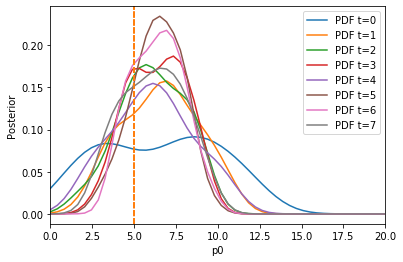

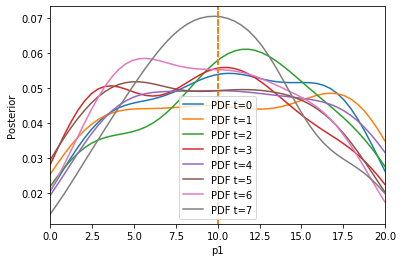

In [15]:
distance = pyabc.AdaptivePNormDistance(p=1, )#factors=factors)

abc = pyabc.ABCSMC(model, prior, distance)

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history2 = abc.run(max_nr_populations=8)

plot_history(history2)

Next, we account for the discrepancy in data point counts by using self-defined scaling factors:

INFO:History:Start <ABCSMC(id=8, start_time=2019-10-07 12:05:20.944089, end_time=None)>
INFO:Epsilon:initial epsilon is 10.032597661344917
INFO:ABC:t:0 eps:10.032597661344917
INFO:ABC:t:1 eps:6.708075558830126
INFO:ABC:t:2 eps:4.663986301692477
INFO:ABC:t:3 eps:3.176604676474282
INFO:ABC:t:4 eps:2.1535030238111466
INFO:ABC:t:5 eps:1.0999490841759532
INFO:ABC:t:6 eps:0.7873927025688306
INFO:ABC:t:7 eps:0.5746775808275074
INFO:History:Done <ABCSMC(id=8, start_time=2019-10-07 12:05:20.944089, end_time=2019-10-07 12:05:51.933020)>


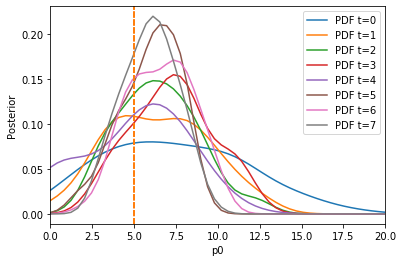

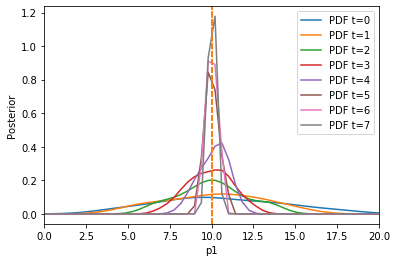

In [16]:
factors = {}
for j in range(N0):
    factors['p0_' + str(j)] = 1/N0
for j in range(N1):
    factors['p1_' + str(j)] = 1/N1
distance = pyabc.PNormDistance(p=1, factors=factors)

abc = pyabc.ABCSMC(model, prior, distance)

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history3 = abc.run(max_nr_populations=8)

plot_history(history3)

Next, we consider automatic weighting and factors:

INFO:History:Start <ABCSMC(id=9, start_time=2019-10-07 12:05:52.698718, end_time=None)>
INFO:Epsilon:initial epsilon is 10.884703735090174
INFO:ABC:t:0 eps:10.884703735090174
INFO:ABC:t:1 eps:7.314640889779031
INFO:ABC:t:2 eps:5.320515167533449
INFO:ABC:t:3 eps:3.844391432784108
INFO:ABC:t:4 eps:2.9567462432830944
INFO:ABC:t:5 eps:2.6061894018063043
INFO:ABC:t:6 eps:2.4217201320475676
INFO:ABC:t:7 eps:2.0588366125064885
INFO:History:Done <ABCSMC(id=9, start_time=2019-10-07 12:05:52.698718, end_time=2019-10-07 12:06:26.413264)>


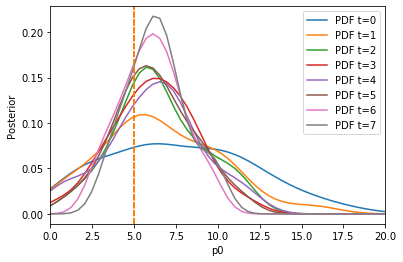

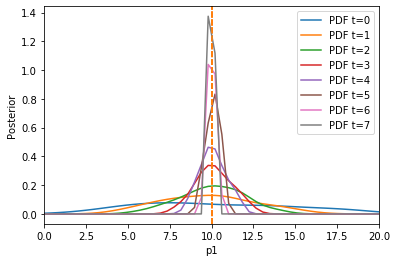

In [17]:
import logging
df_logger = logging.getLogger('Distance')
# df_logger.setLevel(logging.DEBUG)

factors = {}
for j in range(N0):
    factors['p0_' + str(j)] = 1/N0
for j in range(N1):
    factors['p1_' + str(j)] = 1/N1
distance = pyabc.AdaptivePNormDistance(p=1, factors=factors)

abc = pyabc.ABCSMC(model, prior, distance)

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history4 = abc.run(max_nr_populations=8)

plot_history(history4)

The results for the distances that re-factor are best, and in this case fixed and adaptive weights give similar results. In addition to the much better posteriors, the sample numbers are much lower, as the below plots show.

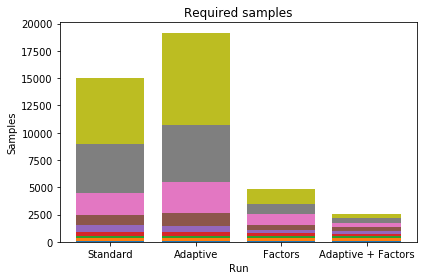

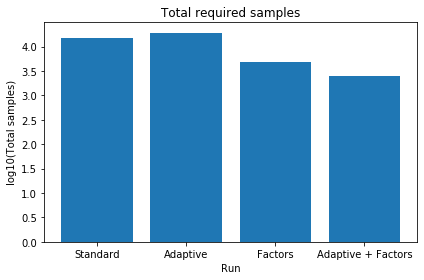

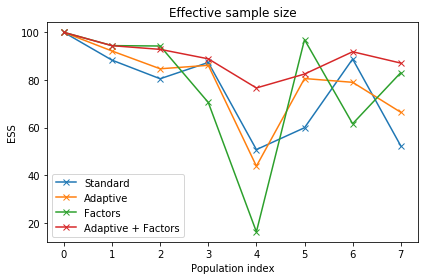

In [18]:
histories = [history1, history2, history3, history4]
labels = ["Standard", "Adaptive", "Factors", "Adaptive + Factors"]

pyabc.visualization.plot_sample_numbers(histories, labels)
pyabc.visualization.plot_total_sample_numbers(histories, labels, yscale='log10')
pyabc.visualization.plot_effective_sample_sizes(histories, labels)